# Package

In [12]:
!pip install selenium
#we also need to do the extra steps below because we need to call the chrome executable from colab
#note that these steps are not necessary if you are running the code from your own computer
!apt-get update # to update ubuntu to correctly run apt install
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
from selenium import webdriver
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
wd = webdriver.Chrome('chromedriver',chrome_options=chrome_options)

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu bionic-security InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:14 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic 

In [13]:
import time
from selenium.webdriver import Chrome
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

import pandas as pd 
import numpy as np
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
import re
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
!pip install pyLDAvis
!pip install gensim

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.parsing.preprocessing import remove_stopwords

# Plotting tools
import pyLDAvis
#import pyLDAvis.gensim #THIS IS OLD, WE NEED TO CHANGE IT TO:
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [15]:
data=[]

wait = WebDriverWait(wd,15)
wd.get("https://www.youtube.com/watch?v=ebdcpdVgBAg") 

#THIS IS THE SAME BUT SHOULD BE INDENTED UNDER WITH TO WORK ON YOUR OWN COMPUTER
for item in range(200): 
 wait.until(EC.visibility_of_element_located((By.TAG_NAME, "body"))).send_keys(Keys.END) 
 #time.sleep(15)

for comment in wait.until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, "#content"))):
  data.append(comment.text)

In [16]:
comment = pd.DataFrame(data, columns=['comment'])

In [17]:
comment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1739 entries, 0 to 1738
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  1739 non-null   object
dtypes: object(1)
memory usage: 13.7+ KB


In [18]:
comment.drop_duplicates(inplace=True)

# Stopword

In [19]:
#remove stopwords using a code from the internet
stop_words_l=(['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an','and','any','are', 'as', 'at', 'be', 'because', 'been', 'before','being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
                     'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
                     'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in','into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
                     'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once','only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
                     's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such', 't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
                     'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was','we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
                     'why', 'will', 'with', 'won', 'y', 'you', 'youd','youll', 'youre','from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'also', 'may', 'take', 'come',
                     'youve', 'your', 'yours', 'yourself', 'yourselves', 'pre', 'ppls', 'doesn', 'ppl', 'patreon', 'com', 'yongyea', 'www', 'twitter', 'tho', 'cke', 'nee', 'aaa', 'ok', 'still', 'and', 've', 'didn', 'sounds', 'ol', 'and', 'seem', 'something'])
comment['comment_cleaned']=comment.comment.apply(lambda x: " ".join(re.sub(r'[^a-zA-Z]',' ',w).lower() for w in x.split() if re.sub(r'[^a-zA-Z]',' ',w).lower() not in stop_words_l) )

In [20]:
df=comment.drop('comment', axis=1)
df

,comment_cleaned
0,skip navigation sign hero wars com ...
1,surprise mechanics merch http www yongyea...
2,put smile face surprise mechanics merch ht...
3,ubisoft nfts future gaming gamers gaming fut...
4,fact single person bought nfts breakpoint beyo...
...,...
1734,nonsense feature trash
1735,nfts stupid asf anyways
1736,whenever hear environmental issues nfts crypto...
1737,c omon yong don t feed them people backla...


In [21]:
# turn to list for preprocessing
data1 = df.values.tolist()
data1

[['skip navigation sign        hero wars com           ad            hero wars com       skip ads internet mock   laugh ubisoft quartz nfts almost nobody buys   weeks launch         viewsdec            k dislike share save     m subscribers join subscribe surprise mechanics  merch   http   www yongyea com patreon  http   www patreon com yongyea twitter  http   www twitter com yongyea show        ad hero wars com                 ubisoft mocked company insist nft  used responsibly     true principles     k views   month ago       ea finally asked tough questions fifa loot boxes   fail miserably answering    k views   months ago mix   youtube         disney s fastpass  complicated history defunctland    m views   months ago         goes   problem nfts folding ideas    m views    days ago         story games u s  gold       all american software   kim justice kim justice    k views   years ago       ubisoft nfts completely failed upper echelon gamers    k views   month ago         fallout 

In [22]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence).encode('utf-8'), deacc=True))
data_words = list(sent_to_words(data1))

In [23]:
print(data_words[:2])

[['skip', 'navigation', 'sign', 'hero', 'wars', 'com', 'ad', 'hero', 'wars', 'com', 'skip', 'ads', 'internet', 'mock', 'laugh', 'ubisoft', 'quartz', 'nfts', 'almost', 'nobody', 'buys', 'weeks', 'launch', 'viewsdec', 'dislike', 'share', 'save', 'subscribers', 'join', 'subscribe', 'surprise', 'mechanics', 'merch', 'http', 'www', 'yongyea', 'com', 'patreon', 'http', 'www', 'patreon', 'com', 'yongyea', 'twitter', 'http', 'www', 'twitter', 'com', 'yongyea', 'show', 'ad', 'hero', 'wars', 'com', 'ubisoft', 'mocked', 'company', 'insist', 'nft', 'used', 'responsibly', 'true', 'principles', 'views', 'month', 'ago', 'ea', 'finally', 'asked', 'tough', 'questions', 'fifa', 'loot', 'boxes', 'fail', 'miserably', 'answering', 'views', 'months', 'ago', 'mix', 'youtube', 'disney', 'fastpass', 'complicated', 'history', 'defunctland', 'views', 'months', 'ago', 'goes', 'problem', 'nfts', 'folding', 'ideas', 'views', 'days', 'ago', 'story', 'games', 'gold', 'all', 'american', 'software', 'kim', 'justice', '

# Bigram and Stuffs

In [24]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [25]:
print(trigram_mod[bigram_mod[data_words[10]]])

['word', 'scam', 'associated', 'nft', 'keep', 'throwing', 'around', 'every', 'time', 'someone', 'brings', 'nft']


In [26]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [27]:
from nltk.tokenize import word_tokenize

In [28]:
import spacy

In [29]:
# Form Bigrams
data_words_bigrams = make_bigrams(data_words)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# LDA Model


In [30]:
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 4), (3, 1), (4, 1), (5, 2), (6, 22), (7, 1), (8, 4), (9, 18), (10, 1), (11, 1), (12, 2), (13, 8), (14, 2), (15, 1), (16, 1), (17, 16), (18, 1), (19, 5), (20, 1), (21, 1), (22, 2), (23, 1), (24, 1), (25, 12), (26, 1), (27, 5), (28, 4), (29, 2), (30, 1), (31, 1), (32, 1), (33, 2), (34, 2), (35, 3), (36, 9), (37, 3), (38, 1), (39, 12), (40, 70), (41, 15), (42, 1), (43, 30), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 2), (51, 2), (52, 1), (53, 2), (54, 2), (55, 2), (56, 1), (57, 1), (58, 3), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 4), (67, 1), (68, 1), (69, 17), (70, 7), (71, 1), (72, 1), (73, 1731), (74, 6), (75, 1), (76, 1), (77, 1), (78, 3), (79, 1), (80, 1), (81, 1), (82, 1), (83, 2), (84, 2), (85, 1), (86, 2), (87, 1), (88, 1), (89, 1), (90, 15), (91, 1), (92, 1), (93, 50), (94, 6), (95, 1), (96, 6), (97, 2), (98, 1), (99, 44), (100, 1), (101, 5), (102, 1), (103, 3), (104, 28), (105, 7), (106, 1), (107, 2), (108, 1), (1

In [31]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=32, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=70,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [32]:
doc_lda = lda_model[corpus]

In [33]:
from pprint import pprint

In [34]:
pprint(lda_model.print_topics())

[(15,
  '0.000*"preacher" + 0.000*"prayer" + 0.000*"prediction" + '
  '0.000*"predictable" + 0.000*"predatory" + 0.000*"precedent" + '
  '0.000*"premise" + 0.000*"pre" + 0.000*"practically" + 0.000*"praise"'),
 (22,
  '0.000*"preacher" + 0.000*"prayer" + 0.000*"prediction" + '
  '0.000*"predictable" + 0.000*"predatory" + 0.000*"precedent" + '
  '0.000*"premise" + 0.000*"pre" + 0.000*"practically" + 0.000*"praise"'),
 (19,
  '0.002*"rinse" + 0.001*"capitalize" + 0.001*"translation" + 0.000*"pray" + '
  '0.000*"practice" + 0.000*"preacher" + 0.000*"pre" + 0.000*"prayer" + '
  '0.000*"predatory" + 0.000*"potentially"'),
 (6,
  '0.003*"blast" + 0.002*"behind" + 0.000*"pre" + 0.000*"prediction" + '
  '0.000*"predictable" + 0.000*"predatory" + 0.000*"precedent" + '
  '0.000*"premise" + 0.000*"preacher" + 0.000*"practically"'),
 (16,
  '0.008*"bright" + 0.001*"satisfy" + 0.001*"quote" + 0.000*"pre" + '
  '0.000*"predatory" + 0.000*"precedent" + 0.000*"preacher" + '
  '0.000*"predictable" + 0.

In [35]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.406480734003384

Coherence Score:  0.5775311632608056


In [36]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word) #HERE WE NEEDED TO CHANGE gensim TO gensim_models
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.207861  0.358634       1        1  60.493815
21     0.058265 -0.070830       2        1  14.289521
9     -0.380118 -0.212572       3        1  14.063428
29    -0.000890 -0.021568       4        1   1.478574
17     0.030939 -0.015317       5        1   1.236626
31     0.033498 -0.009462       6        1   1.163564
3      0.028477 -0.007867       7        1   0.798837
4      0.027213 -0.012148       8        1   0.780021
12     0.029525 -0.008799       9        1   0.771048
30     0.026772 -0.002875      10        1   0.549407
23     0.026275 -0.002649      11        1   0.489676
7      0.027197 -0.003084      12        1   0.466971
20     0.027743 -0.005017      13        1   0.436459
8      0.024885 -0.002067      14        1   0.369839
11     0.029973 -0.005625      15        1   0.338318
26     0.022794 -0.001212      16        1   0.324541
10     0.022297 -0.001070      17        1   0.297158
28     0.015964  0.000572      18        1   0.285479
18     0.021080 -0.000810      19        1   0.251014
0      0.019758 -0.000340      20        1   0.199140
25     0.025198 -0.002220      21        1   0.186925
14     0.018555  0.000049      22        1   0.184239
13     0.014748  0.001119      23        1   0.141218
1      0.012776  0.001485      24        1   0.100833
27     0.006717  0.002742      25        1   0.061018
24     0.006798  0.002726      26        1   0.054386
5      0.005416  0.003003      27        1   0.039029
6      0.005312  0.003009      28        1   0.037149
16     0.005680  0.002937      29        1   0.036620
19     0.005183  0.003028      30        1   0.033199
15     0.004915  0.003113      31        1   0.020973
22     0.004915  0.003113      32        1   0.020972, topic_info=                Term         Freq        Total Category  logprob  loglift
73               ago   905.000000   905.000000  Default  30.0000  30.0000
2188           month   852.000000   852.000000  Default  29.0000  29.0000
2857           reply   632.000000   632.000000  Default  28.0000  28.0000
1408            game  1286.000000  1286.000000  Default  27.0000  27.0000
2278             nft  1354.000000  1354.000000  Default  26.0000  26.0000
...              ...          ...          ...      ...      ...      ...
25           account     0.002298    16.318390  Topic32  -8.2764  -0.3983
26    accountability     0.002298     1.656398  Topic32  -8.2764   1.8893
27           achieve     0.002298     2.857343  Topic32  -8.2764   1.3441
28       achievement     0.002298     4.270337  Topic32  -8.2764   0.9423
29       acknowledge     0.002298     5.288145  Topic32  -8.2764   0.7285

[1409 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
0         1  0.401996           aaa
1         1  0.574970          aale
2         1  0.662066       abandon
3        12  0.456045  abbreviation
4         2  0.629178     abendroid
...     ...       ...           ...
3907     11  0.532606       writing
3905     11  0.532606        xddddd
3852     11  0.870951          yong
3860      5  0.857353           yup
3864      5  0.663737          zero

[476 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 22, 10, 30, 18, 32, 4, 5, 13, 31, 24, 8, 21, 9, 12, 27, 11, 29, 19, 1, 26, 15, 14, 2, 28, 25, 6, 7, 17, 20, 16, 23])

# LDA Mallet


In [37]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

--2022-02-02 05:34:09--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip [following]
--2022-02-02 05:34:10--  https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  7.56MB/s    in 2.0s    

2022-02-02 05:34:12 (7.56 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]

Archive:  mallet-2.0.8.zip
   creating: mallet-2.0.8/
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.

In [38]:
import os
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet'

In [39]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=32, id2word=id2word)

In [40]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(18,
  [('money', 0.2071563088512241),
   ('pay', 0.15160075329566855),
   ('developer', 0.0583804143126177),
   ('win', 0.05743879472693032),
   ('publisher', 0.03389830508474576),
   ('product', 0.030131826741996232),
   ('executive', 0.022598870056497175),
   ('currency', 0.022598870056497175),
   ('vote', 0.0160075329566855),
   ('suit', 0.014124293785310734)]),
 (10,
  [('company', 0.2680722891566265),
   ('push', 0.11244979919678715),
   ('hope', 0.0853413654618474),
   ('find', 0.03815261044176707),
   ('idiot', 0.029116465863453816),
   ('customer', 0.023092369477911646),
   ('shitty', 0.02208835341365462),
   ('eventually', 0.019076305220883535),
   ('negative', 0.018072289156626505),
   ('sadly', 0.01606425702811245)]),
 (29,
  [('game', 0.3766769865841073),
   ('turn', 0.0412796697626419),
   ('dlc', 0.038183694530443756),
   ('ve', 0.022703818369453045),
   ('reason', 0.021671826625386997),
   ('finish', 0.018575851393188854),
   ('expansion', 0.016511867905056758),
   ('e

# New Section

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

TypeError: ignored

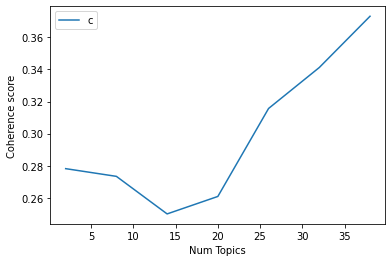

In [ ]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2782
Num Topics = 8  has Coherence Value of 0.2734
Num Topics = 14  has Coherence Value of 0.2501
Num Topics = 20  has Coherence Value of 0.2609
Num Topics = 26  has Coherence Value of 0.3157
Num Topics = 32  has Coherence Value of 0.3412
Num Topics = 38  has Coherence Value of 0.373


In [ ]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.101*"pay" + 0.054*"stupid" + 0.044*"industry" + 0.029*"developer" + '
  '0.029*"transaction" + 0.026*"call" + 0.025*"cash" + 0.023*"micro" + '
  '0.021*"product" + 0.019*"rich"'),
 (1,
  '0.212*"money" + 0.066*"make" + 0.037*"hate" + 0.032*"purchase" + '
  '0.031*"spend" + 0.025*"scheme" + 0.025*"lose" + 0.024*"stay" + 0.020*"high" '
  '+ 0.019*"person"'),
 (2,
  '0.121*"item" + 0.095*"player" + 0.080*"make" + 0.068*"unique" + '
  '0.044*"number" + 0.041*"skin" + 0.036*"base" + 0.029*"create" + '
  '0.020*"system" + 0.018*"gameplay"'),
 (3,
  '0.146*"sell" + 0.067*"time" + 0.060*"market" + 0.044*"world" + '
  '0.034*"price" + 0.032*"dumb" + 0.029*"cosmetic" + 0.027*"free" + '
  '0.027*"trade" + 0.026*"steam"'),
 (4,
  '0.070*"ghost" + 0.056*"recon" + 0.047*"breakpoint" + 0.043*"digital" + '
  '0.030*"garbage" + 0.029*"fuck" + 0.025*"feel" + 0.025*"fan" + 0.024*"live" '
  '+ 0.021*"armor"'),
 (5,
  '0.093*"ubisoft" + 0.092*"put" + 0.063*"big" + 0.046*"happen" + '
  '0.034*"sta

In [ ]:
# Compute Coherence Score
coherence_model_optimal = CoherenceModel(model=optimal_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_optimal = coherence_model_optimal.get_coherence()
print('\nCoherence Score: ', coherence_optimal)


Coherence Score:  0.7614381832570629


In [ ]:
from gensim.models.ldamodel import LdaModel
def convertldaGenToldaMallet(mallet_model):
    model_gensim = LdaModel(
        id2word=mallet_model.id2word, num_topics=mallet_model.num_topics,
        alpha=mallet_model.alpha, eta=0,
    )
    model_gensim.state.sstats[...] = mallet_model.wordtopics
    model_gensim.sync_state()
    return model_gensim

In [ ]:
optimal=convertldaGenToldaMallet(optimal_model)